Sun, Keanna Louie 

CMSC 197 ML

## Linear Regression with Gradient Descent (from Scratch)

Create a model for advertising data without using scikitlearn

In [1]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, scale

##### For Building the Model #####
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline

##### For Validation of the Model #####
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

##### random module ######
import random

### Step 1: Load dataset

In [2]:
df = pd.read_csv("Advertising.csv", index_col=0)
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
df.shape

(200, 4)

<b> Insert bias column </b>

In [4]:
df.insert(0, "Bias", [1]*df.shape[0])

In [5]:
df.head()

,Bias,TV,Radio,Newspaper,Sales
1,1,230.1,37.8,69.2,22.1
2,1,44.5,39.3,45.1,10.4
3,1,17.2,45.9,69.3,9.3
4,1,151.5,41.3,58.5,18.5
5,1,180.8,10.8,58.4,12.9


#### General form of MLR
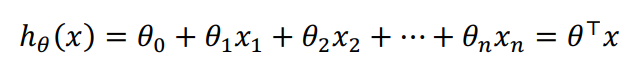

### Step 2: Standardize Values

Using preprocessing.scale and doing it from scratch

In [6]:
df.dtypes

Bias           int64
TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

In [7]:
# keep old means and standard deviations to destandardize later on
TV_mean = df.TV.mean()
TV_std =  df.TV.std()
radio_mean =  df.Radio.mean()
radio_std =  df.Radio.std()
newspaper_mean =  df.Newspaper.mean()
newspaper_std =  df.Newspaper.std()
sales_mean =  df.Sales.mean()
sales_std =  df.Sales.std()

In [8]:
df['TV'] = df.TV.apply(lambda x: (x - df.TV.mean()) /  df.TV.std())
df['Radio'] = df.Radio.apply(lambda x: (x - df.Radio.mean()) /  df.Radio.std())
df['Newspaper'] = df.Newspaper.apply(lambda x: (x - df.Newspaper.mean()) /  df.Newspaper.std())
df['Sales'] = df.Sales.apply(lambda x: (x - df.Sales.mean()) /  df.Sales.std())

In [9]:
df.head(10)

,Bias,TV,Radio,Newspaper,Sales
1,1,0.967425,0.979066,1.774493,1.548168
2,1,-1.194379,1.080097,0.667903,-0.694304
3,1,-1.512360,1.524637,1.779084,-0.905135
4,1,0.051919,1.214806,1.283185,0.858177
5,1,0.393196,-0.839507,1.278593,-0.215143
6,1,-1.611365,1.726701,2.040809,-1.307629
7,1,-1.042960,0.642293,-0.323896,-0.425974
8,1,-0.312652,-0.246787,-0.870303,-0.157644
9,1,-1.612530,-1.425491,-1.357019,-1.767624
10,1,0.614501,-1.391814,-0.429504,-0.655971


### Step 4: Divide Data into Testing and Training

Training = 0.85, testing = 0.15

In [10]:
x = df.drop('Sales', axis=1)
y = df.Sales

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state = 42)

In [12]:
print(x_train)
print(y_train)

     Bias        TV     Radio  Newspaper
10      1  0.614501 -1.391814  -0.429504
19      1 -0.906682 -0.186168  -0.562662
56      1  0.604018  1.760378   1.352060
76      1 -1.515854  1.376457   2.702008
151     1  1.556796 -0.630708   0.295978
..    ...       ...       ...        ...
107     1 -1.421508 -0.826036  -0.039213
15      1  0.664586  0.649028   0.709228
93      1  0.822994  0.689441   1.306143
180     1  0.216151 -0.893391  -0.594804
103     1  1.550972 -0.886655  -0.420320

[170 rows x 4 columns]
10    -0.655971
19    -0.521806
56     1.854831
76    -1.020133
151    0.398183
         ...   
107   -1.307629
15     0.954009
93     1.030675
180   -0.272642
103    0.149019
Name: Sales, Length: 170, dtype: float64


### Step 5: Fitting the Model
Defining functions that will be used to fit the model and training the model using training data.

In [50]:
def initialize_weights():
    # generate random numbers between 0 and 1
    random.seed(42)
    j_0 = random.uniform(0, 1)
    j_1 = random.uniform(0, 1)
    j_2 = random.uniform(0, 1)
    j_3 = random.uniform(0, 1)
    return np.array([j_0, j_1, j_2, j_3])
    #init_w = np.array([0.0, 0.0, 0.0, 0.0])
    #return init_w

In [51]:
# run to check if it produces the sae random numbers
initialize_weights()

array([0.6394268 , 0.02501076, 0.27502932, 0.22321074])

In [52]:
# predicted sales model that returns a vector of predicted sales
def predict(weights, x):
    #return init_w[0] + init_w[1]*x + init_w[2]*y + init_w[3]*z
    return np.dot(x, weights)

    #this returns the same results: return np.sum(np.multiply(weights, x), axis=1)

In [53]:
def compute_cost(y_hat, y):
    # difference of predicted and squared (model(xyz) - sales)^2
    error = (y_hat - y)
    
    # cost: (1/2m) * sum((y_hat - y)**2) --> (1/2m) * error.T
    cost = (1/(2*y.shape[0])) * np.dot(error.T, error)
    
    return cost


In [54]:
def compute_gradient(y_hat, y, x):
    # get error first
    error = (y_hat - y)
    
    # partial derivative: (1/m) * sum((y_hat-y)*x)
    partial_derivative = (np.dot(x.T, error)) / y.shape[0]
    return partial_derivative

In [55]:
def update_weights(weights, gradients, alpha):
    
    return weights - (alpha*gradients)
    

In [56]:
def grad_descent(x, y, iterations, alpha):
    # variabel;s for keeping the costs and weights per iteration
    costs_matrix = []
    thetas_matrix = []
    
    # initialize random weights first
    init_w = initialize_weights()
    
    for i in range(iterations):
        
        # get predicted sales using randomly initialized weights
        y_hat = predict(init_w, x)
        #print(y_hat)
        
        # compute cost of weights
        costs = compute_cost(y_hat, y)
        #print(costs)
        
        # compute partial derivatives of given weights
        gradients = compute_gradient(y_hat, y, x)
        #print(gradients)

        # update value of weights
        # alpha = 0.01       # change this 
        init_w = update_weights(init_w, gradients, alpha)
        #print(init_w)
        
        # concatenate to matrices
        costs_matrix.append(costs)
        thetas_matrix.append(init_w)
        
        #print("{} \t  {}".format(init_w, costs))
    
    return thetas_matrix, costs_matrix
 
    

In [57]:
def plot_costs(cost):
    costs = pd.DataFrame(cost, columns=['Costs'])
    
    # define dimensions
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    # call lineplot of seaborn
    sns.lineplot(data=costs, ax=ax)
    plt.show()

### Step 6: Predict y using training data and its cost

#### Train model and get weights and costs

In [58]:
weights, costs = grad_descent(x_train, y_train, 400, 0.01)

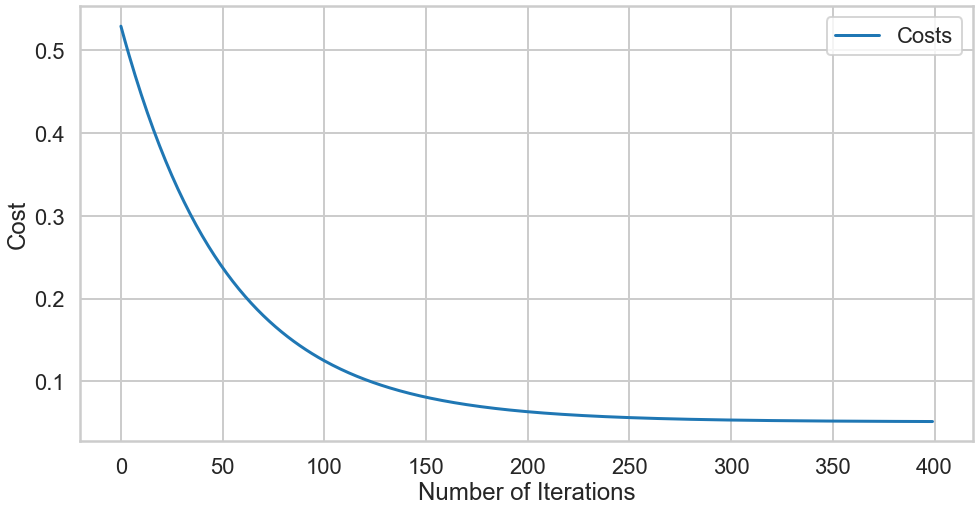

In [59]:
plot_costs(costs)

In [60]:
# see the last 20 costs 
costs[-20:]

[0.05173508641253715,
 0.051725284667905394,
 0.05171563841620873,
 0.051706145059117484,
 0.05169680204355826,
 0.0516876068609011,
 0.05167855704616144,
 0.05166965017721697,
 0.051660883874038596,
 0.051652255797935705,
 0.051643763650815154,
 0.051635405174453856,
 0.05162717814978479,
 0.05161908039619599,
 0.051611109770842364,
 0.05160326416797024,
 0.0515955415182541,
 0.051587939788145604,
 0.05158045697923442,
 0.051573091127620825]

#### Predicted sales (and cost) for training data

In [61]:
# used weights[-1] bcos we want to use the weights that produced the least cost
y_hat = predict(weights[-1], x_train)
y_hat

array([-0.27325587, -0.75318546,  1.39866291, -0.29397577,  0.82159141,
        1.13319251, -0.01911482,  1.31420525, -0.56769379, -1.75917079,
       -0.79868117, -0.25100881, -0.73536083, -1.08632605, -0.08372366,
       -1.60488178, -0.86905048,  0.02368478, -0.9497049 , -0.45266378,
        0.25916715, -0.39174638, -0.20053288, -0.58775793, -1.38298677,
       -0.74493319, -0.84665533,  1.90447981, -1.18633122, -0.2801785 ,
        0.69752438,  0.24298001, -0.46705557, -0.565634  ,  0.52779869,
       -1.32392764,  1.36525167, -1.464188  , -0.75991925, -0.48771234,
       -0.88900861, -1.38607573,  0.17611829,  0.6297526 ,  0.37200744,
        0.42240452,  0.16627171,  1.01410338,  0.01308004,  1.31457164,
       -0.24078303, -0.04808514, -0.92722688,  0.5583622 , -1.05374466,
        0.27870237, -0.04159166,  1.70516983, -0.30209892,  1.68384551,
       -1.34438325,  0.88757393,  1.81609532,  0.85951576,  0.57507196,
        0.43434868, -0.27913691, -0.41671944,  0.55911117,  0.10

In [62]:
compute_cost(y_hat, y_train)

0.051565840303299686

In [63]:
# check MSE 
mean_squared_error(y_train, y_hat)

0.10313168060659934

### Step 7: Predict y using test data and its cost

#### Predicted sales for testing data

In [64]:
#weights_test, costs_test = grad_descent(x_test, y_test, 200)
#costs_test[-20:]

In [65]:
y_hat_test = predict(weights[-1], x_test)
y_hat_test

array([ 0.47007167,  1.30085072,  1.43365798, -0.6315276 ,  1.49160937,
       -0.15429185,  1.3155401 , -1.22455779, -0.06560081,  0.22496312,
       -0.94857087, -1.36320823,  0.12875699, -0.97446628, -0.79131445,
       -0.32332418, -0.97986038,  0.41990775, -0.69047902,  0.89705503,
        1.07920572, -0.08095611, -0.33471047,  1.40313554, -1.16726784,
       -1.52546817,  1.26493914, -0.38242307, -0.89476249, -1.05263541])

In [66]:
compute_cost(y_hat_test, y_test)

0.05554248236464029

In [67]:
# check MSE
mean_squared_error(y_test, y_hat_test)

0.11108496472928057

### Step 8: De-standardize quantitative response y of both training and test data

In [68]:
df2 = pd.DataFrame()

In [69]:
df2['TV'] = df.TV.apply(lambda x: (x * TV_std + TV_mean))
df2['Radio'] = df.Radio.apply(lambda x: (x * radio_std + radio_mean))
df2['Newspaper'] = df.Newspaper.apply(lambda x: (x * newspaper_std + newspaper_mean))
df2['Sales'] = df.Sales.apply(lambda x: (x * sales_std + sales_mean))

In [70]:
df2.head(3)

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3


In [71]:
x2 = df2.drop('Sales', axis=1)
y2 = df2.Sales

In [72]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state = 42)

In [73]:
y_hat2 = predict(weights[-1], x_train2)

In [74]:
compute_cost(y_hat2, y_train2)

0.051565840303299686

In [75]:
y_hat_test2 = predict(weights[-1], x_test)

In [76]:
compute_cost(y_hat_test2, y_test2)

0.05554248236464029

In [77]:
mean_squared_error(y_train2, y_hat2)

0.10313168060659934

In [78]:
mean_squared_error(y_test2, y_hat_test2)

0.11108496472928057

The costs and MSE of the standardized and the original datasets are similar, so we can say that even if the data wasn't normalized, we could still produce similar results.

### Checking Code Against Scikit-learn OLS
using standardized training and test data

In [79]:
model = LinearRegression().fit(x_train, y_train)

Coefficient of determination (R2)

In [80]:
r_squared = model.score(x_train, y_train)
r_squared

0.8936793584593189

In [81]:
r_squared_test = model.score(x_test, y_test)
r_squared_test

0.9110275702091715

Test data predictions

In [82]:
predictions = model.predict(x_test)
predictions

array([ 0.44441111,  1.30168679,  1.43691235, -0.66730857,  1.55533551,
       -0.19033088,  1.34451196, -1.25613029, -0.07239572,  0.21395403,
       -0.9477649 , -1.4143734 ,  0.04187445, -0.9794427 , -0.82941714,
       -0.35860114, -1.02352749,  0.43360346, -0.72253191,  0.92669059,
        1.04134773, -0.18638735, -0.32341141,  1.3765889 , -1.1785509 ,
       -1.57241482,  1.28461088, -0.38557956, -0.92832092, -1.05226106])

Predictions of scratch code (standardized)

In [83]:
y_hat_test

array([ 0.47007167,  1.30085072,  1.43365798, -0.6315276 ,  1.49160937,
       -0.15429185,  1.3155401 , -1.22455779, -0.06560081,  0.22496312,
       -0.94857087, -1.36320823,  0.12875699, -0.97446628, -0.79131445,
       -0.32332418, -0.97986038,  0.41990775, -0.69047902,  0.89705503,
        1.07920572, -0.08095611, -0.33471047,  1.40313554, -1.16726784,
       -1.52546817,  1.26493914, -0.38242307, -0.89476249, -1.05263541])

Weights given by Scikit-learn

In [84]:
model.coef_

array([0.        , 0.73738315, 0.53630718, 0.00314254])

### QUESTIONS

<i> 1. What are the optimal weights found by your implemented gradient descent? What are your interpretations regarding the formed linear model? </i>

The weights if the initialized weights are generated randomly are below

In [85]:
weights[-1]

array([0.01414984, 0.7227366 , 0.51692293, 0.02809588])

The optimal weights if weights were initilized as 0 are:

h0(x) = 0.00218526 + 0.72460531 * TV + 0.51470896 * Radio + 0.02698926 * Newspaper

By looking at this linear model, you can say that TV has a bigger impact on sales as it has a bigger weight while Newspaper has the least impact on sales.


<i> 2. Provide a scatter plot of the y_hat and y for both the train and test set. Is there a trend? Provide an r2 score (also available in sklearn). </i>

<b>y_hat vs y of training data</b>

In [86]:
# using standardized values
r2_score(y_train, y_hat)

0.8926671688577971

<AxesSubplot:title={'center':'y_hat vs y of Training Data'}, xlabel='Predicted sales', ylabel='Sales'>

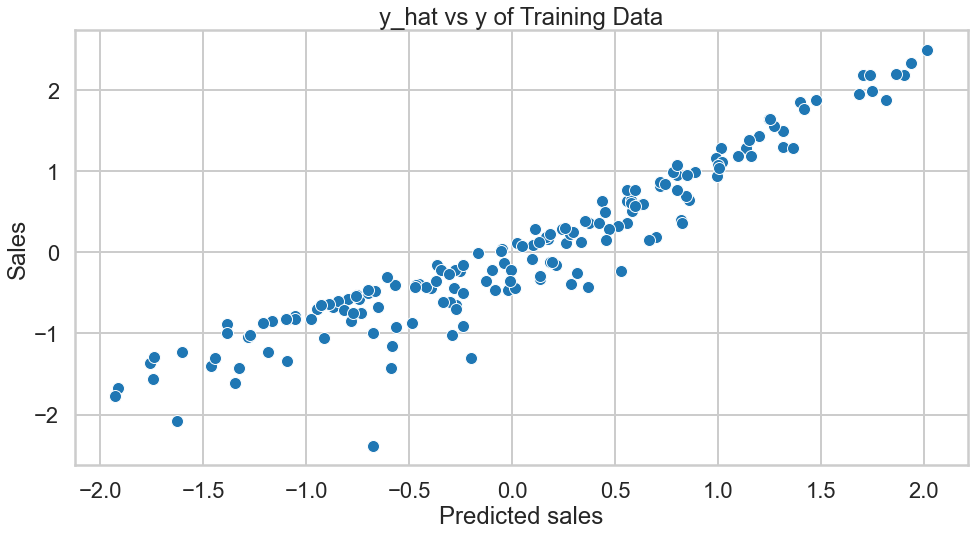

In [87]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("y_hat vs y of Training Data")
plt.xlabel("Predicted sales")
sns.scatterplot(x=y_hat, y=y_train, ax=ax)

<b>y_hat vs y of test data</b>

In [88]:
r2_score(y_test, y_hat_test)

0.9057328737703468

<AxesSubplot:title={'center':'y_hat vs y of Test Data'}, xlabel='Predicted sales', ylabel='Sales'>

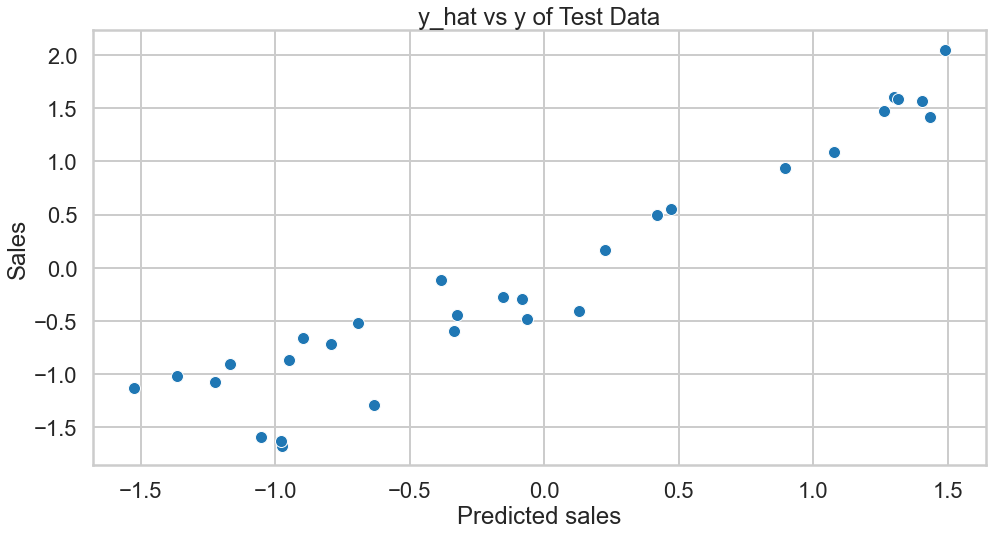

In [89]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("y_hat vs y of Test Data")
plt.xlabel("Predicted sales")
sns.scatterplot(x=y_hat_test, y=y_test, ax=ax)

You can see that both plots approximately form a linear line, implying that when the actual sales get larger, the predicted sales get larger too. You can also observe that the data is not too scattered, so that measn the model produced by the gradient descent produces a good approximation of the response variable y (sales), except for a few outliers.

<i> 3. What happens to the error, r2, and cost as the number of iterations increase? Show your data and proof. You can alternatively plot your result data for visualization and check until 50000 iterations or more (actually). </i>

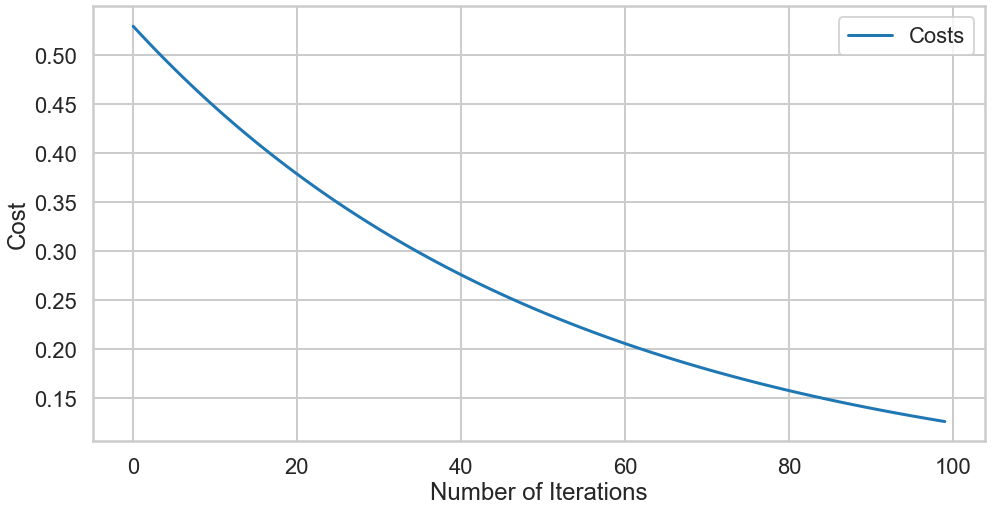

In [90]:
weights2, costs2 =  grad_descent(x_train, y_train, 100, 0.01)
plot_costs(costs2)

In [91]:
y_hat_100 = predict(weights2[-1], x_train)
print("Error: \n", y_train - y_hat_100)
print("R2:\n", r2_score(y_train, y_hat_100))

Error: 
 10    -0.546344
19    -0.184286
56     0.403360
76    -1.517259
151   -0.352394
         ...   
107   -0.539350
15     0.028509
93    -0.071377
180   -0.160490
103   -0.389466
Name: Sales, Length: 170, dtype: float64
R2:
 0.7398554981237123


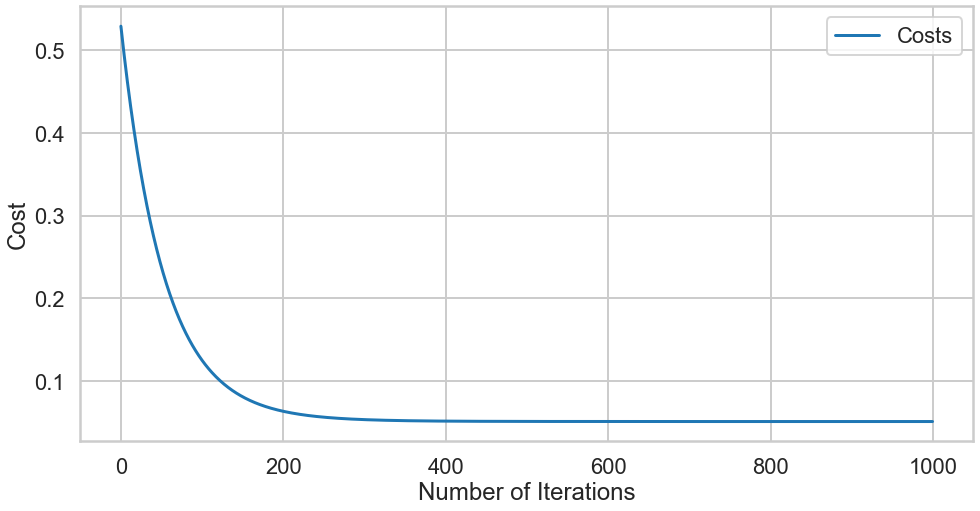

In [92]:
weights2, costs2 =  grad_descent(x_train, y_train, 1000, 0.01)
plot_costs(costs2)

In [93]:
y_hat_1000 = predict(weights2[-1], x_train)
r2_score(y_train, y_hat_1000)
print("Error: \n", y_train - y_hat_1000)
print("R2:\n", r2_score(y_train, y_hat_1000))

Error: 
 10    -0.362337
19     0.248165
56     0.460728
76    -0.650671
151   -0.413517
         ...   
107    0.182701
15     0.113063
93     0.048968
180    0.048362
103   -0.518511
Name: Sales, Length: 170, dtype: float64
R2:
 0.8936788072616394


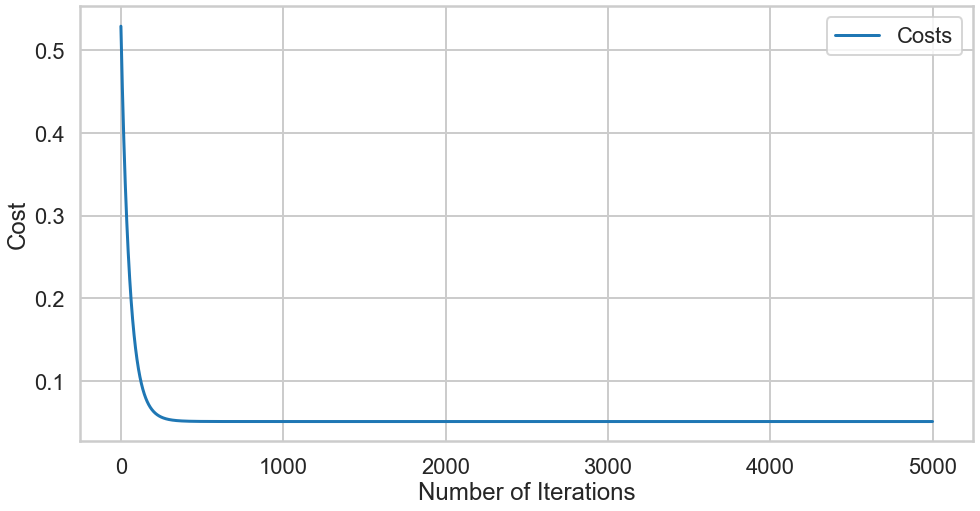

In [94]:
weights2, costs2 = grad_descent(x_train, y_train, 5000, 0.01)
plot_costs(costs2)

In [95]:
y_hat_5000 = predict(weights2[-1], x_train)
r2_score(y_train, y_hat_5000)
print("Error: \n", y_train - y_hat_5000)
print("R2:\n", r2_score(y_train, y_hat_5000))

Error: 
 10    -0.361739
19     0.247942
56     0.460650
76    -0.649499
151   -0.412885
         ...   
107    0.183263
15     0.113212
93     0.049520
180    0.048537
103   -0.518237
Name: Sales, Length: 170, dtype: float64
R2:
 0.8936793584593189


In the plots above, you can see that as the number of iterations increase, costs get closer and closer to 0.05. The errors between y_train and the predicted y of each model also get smaller. The R2 score gets bigger as more iterations are done on the model, but between the models with 1000 and 5000 iterations, their differences are very small and negligible so we can say that 1000 iterations can more than suffice. 

4. Once you determine the optimal number of iterations, check the effect on the cost and error as you change the learning rate. The common learning rates in machine learning include 0.1, 0.01, 0.001, 0.0001, 0.2 but you have the option to include others. Visualizethe cost function (vs the optimal number of iterations) of each learning rate in ONLY ONE PLOT. Provide your analysis.

In [ ]:
# get costs of each learning rate
weight_1, cost_1 = grad_descent(x_train, y_train, 400, 0.1)
weight_01, cost_01 = grad_descent(x_train, y_train, 400, 0.01)
weight_001, cost_001 = grad_descent(x_train, y_train, 400, 0.001)
weight_0001, cost_0001 = grad_descent(x_train, y_train, 400, 0.0001)
weight_2, cost_2 = grad_descent(x_train, y_train, 400, 0.2)

In [ ]:
# make arrays into dataframe
cost_1 = pd.DataFrame(cost_1, columns=['Cost'])
cost_01 = pd.DataFrame(cost_01, columns=['Cost'])
cost_001 = pd.DataFrame(cost_001, columns=['Cost'])
cost_0001 = pd.DataFrame(cost_0001, columns=['Cost'])
cost_2 = pd.DataFrame(cost_2, columns=['Cost'])

# concatenate all dataframes
df_costs = pd.concat([cost_1, cost_01, cost_001, cost_0001, cost_2], axis=1, keys=['0.1', '0.01', '0.001', '0.0001', '0.2'])

In [ ]:
# define dimensions
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
# call lineplot of seaborn
sns.lineplot(data=df_costs, ax=ax, palette=['r', 'g', 'b', 'y', '#a1c9f4'], )
plt.show()

When the learning rate is too small, such as 0.0001 or 0.001, the cost remains large for the model that gradient descent produces (for 400 iterations). Meanwhile, when the learning rate is too large, scuh as 0.2 or 0.1, the cost function returns too steep and is not the appropriate learning rate for the number of iterations provided as it takes too big of a step every iteration. If the learning rate is just right, like 0.01 for this dataset, the costs change gradually for each iteration and you can see how the cost reduces as it iterates, until it reaches a considerable minimum.

5. Is there a relationship on the learning rate and the number of iterations?

When learning rate is too small, you will need a lot more iterations to be able to produce a model that gives a very minimumum cost, which takes up too much time and resources. If the number of iterations is too small and the learning rate is large, gradient descent will not be able to give you a model that produces the minimum cost since it can take too big steps and skip over the minimum cost or may not even reach the minimum. 

When you drastically increase the number of iterations, you must considerably lower the learning rate so that the the estimated weights for each iteratio will only change gradually, and eventually reach minimum cost.

6. Compare the results with the results of ordinary least squares function.

In [ ]:
print("R2 score of OLS: ", r_squared)
print("R2 score of gradient descent form scratch: ", r2_score(y_test, y_hat_test))

In [ ]:
print("OLS predictions: ", predictions)

In [ ]:
print("Scratch Gradient Descent Predictions: ", y_hat_test)

Based on the R2 score of the OLS function of scikit-learn and of the gradient descent from scratch, you can say that the scratch code did better since it has a higher R2 score, though the difference between then is miniscule.